In [1]:
import numpy as np
import cv2
from PIL import Image,ImageEnhance
import copy
import matplotlib.pyplot as plt
import random
from utils import helper as hp, preprocess_aug as praug
import pandas as pd
import os
from tqdm.notebook import tqdm_notebook as tqnb
import time
plt.rcParams["figure.figsize"] = (15,10)

### Data Reading & Cleaning

In [2]:
impath = 'data/kitti/integration/original/training/image_2/'
labels_path = 'data/kitti/integration/original/training/label_2/'
imlabel_list = hp.imlabel(impath, labels_path)
imlabel_list[:3]

[('data/kitti/integration/original/training/image_2/2007_000027.jpg',
  'data/kitti/integration/original/training/label_2/2007_000027.txt'),
 ('data/kitti/integration/original/training/image_2/2007_000032.jpg',
  'data/kitti/integration/original/training/label_2/2007_000032.txt'),
 ('data/kitti/integration/original/training/image_2/2007_000033.jpg',
  'data/kitti/integration/original/training/label_2/2007_000033.txt')]

Original dimensions:  (394, 500, 3)


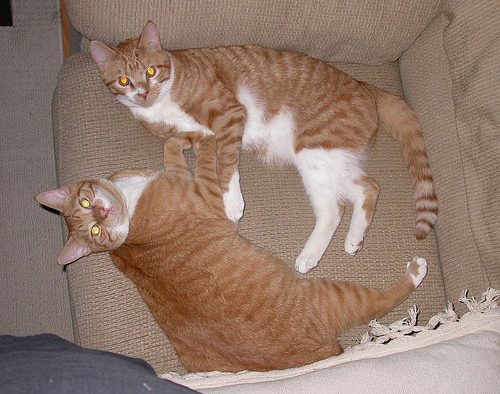

In [3]:
index = 2512
test_img = Image.open(imlabel_list[index][0])
test_img_arr = np.array(test_img)
print("Original dimensions: ",test_img_arr.shape)
test_img

Updated dimensions:  (512, 512, 3)


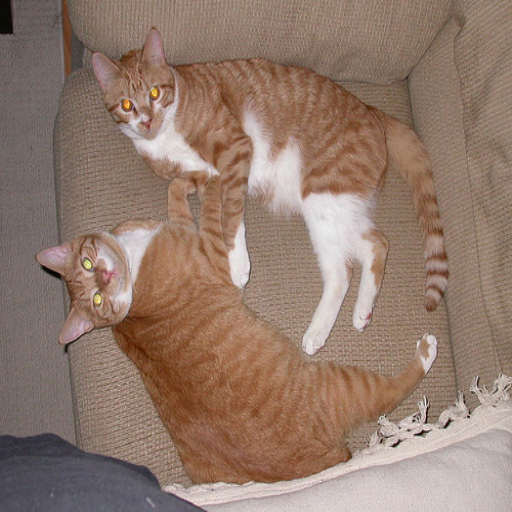

In [4]:
img_arr, bboxes = hp.resize_img_bbox((imlabel_list[index][0],imlabel_list[index][1]), (512,512))
# im_rgb_test = cv2.cvtColor(img_arr.astype('float32'), cv2.COLOR_BGR2RGB)
Image.fromarray(hp.conv2uint8(img_arr))

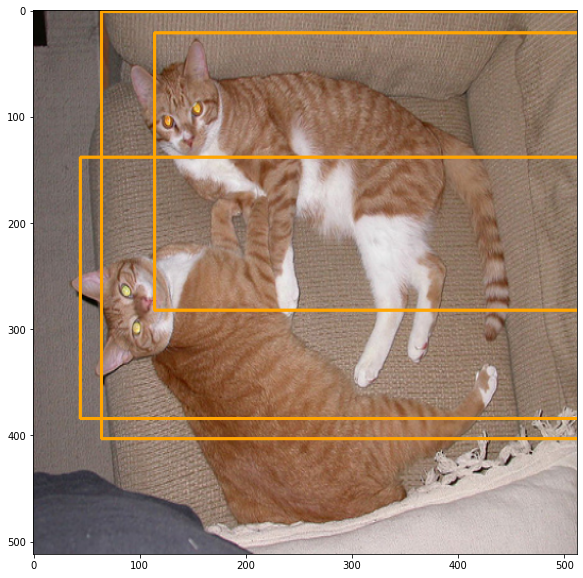

In [5]:
bbox_img = Image.fromarray(hp.draw_bbox(hp.conv2uint8(img_arr),
                                     bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_img)

In [6]:
imlabel_list[index][1]

'data/kitti/integration/original/training/label_2/2008_003559.txt'

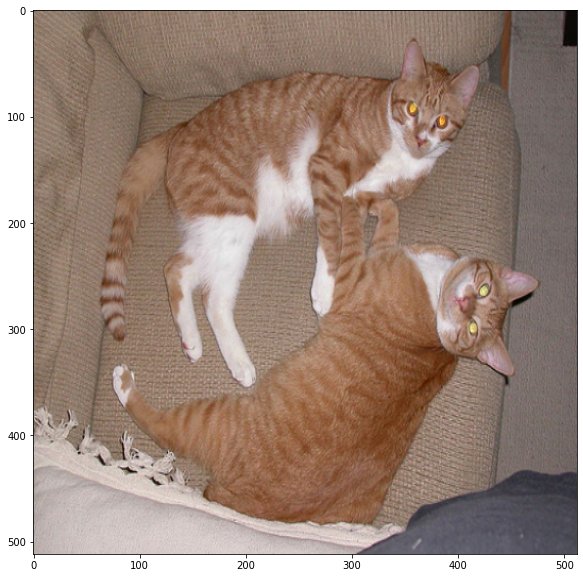

In [7]:
plt.imshow(Image.fromarray(hp.conv2uint8(img_arr)[:,::-1,:]))

In [8]:
# imlabel_list[index][0],imlabel_list[index][1]
spat_aug = praug.Spatial_Aug(image_path=imlabel_list[index][0], 
                       label_path=imlabel_list[index][1])
print("Image shape: ", spat_aug.image_arr.shape)
print("Image bboxes:\n-------------------------------------------------\n",spat_aug.bboxes)
spat_aug = spat_aug.hflip()

Image shape:  (394, 500, 3)
Image bboxes:
-------------------------------------------------
 [[ 88.  21. 439. 276.]
 [ 34. 135. 429. 375.]
 [ 50.   1. 500. 394.]]


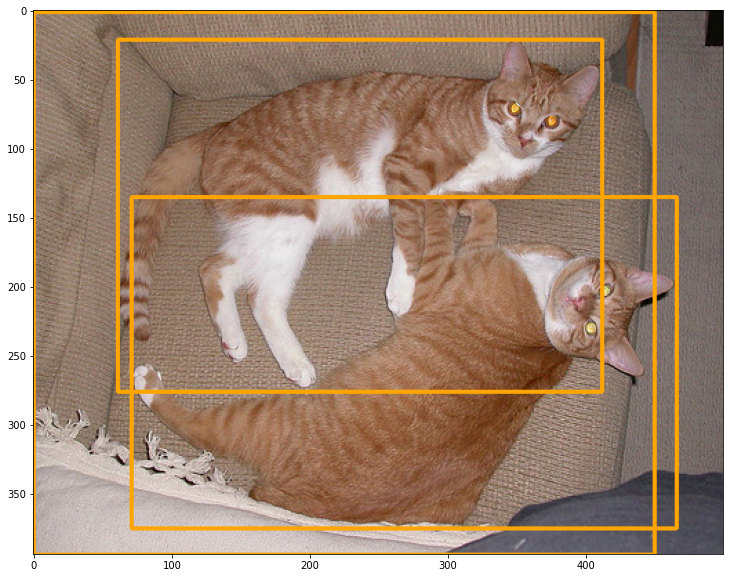

In [9]:
# spat_aug_rgb = cv2.cvtColor(spat_aug.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
bbox_flipim = Image.fromarray(hp.draw_bbox(hp.conv2uint8(spat_aug.image_arr),
                                     spat_aug.bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_flipim)

In [10]:
print("Bounding boxes before translation:\n", spat_aug.bboxes)
spat_aug_shift = praug.Spatial_Aug(image_path=imlabel_list[index][0], 
                       label_path=imlabel_list[index][1])
spat_aug_shift = spat_aug_shift.translate((8,8))
print("\n10th index of augmented image array:\n", spat_aug_shift.image_arr[10])
print("\nBounding boxes after translation:\n", spat_aug_shift.bboxes)

Bounding boxes before translation:
 [[ 61.  21. 412. 276.]
 [ 71. 135. 466. 375.]
 [  0.   1. 450. 394.]]

10th index of augmented image array:
 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.5697458  0.47624847 0.41583565]
 [0.5892885  0.49198073 0.43794042]
 [0.55576366 0.4560126  0.40833336]]

Bounding boxes after translation:
 [[ 94.21315783  21.71233699 445.21315783 276.71233699]
 [ 40.21315783 135.71233699 435.21315783 375.71233699]
 [ 56.21315783   1.71233699 506.21315783 394.71233699]]


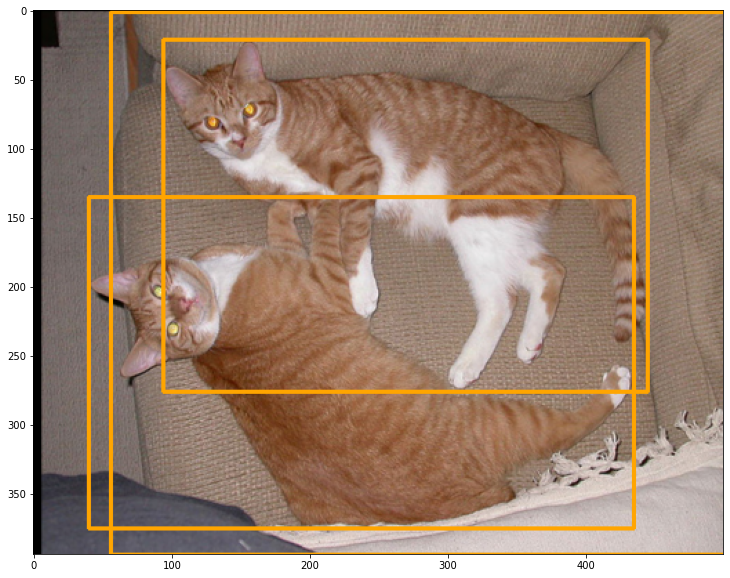

In [11]:
shfbbox_img = Image.fromarray(hp.draw_bbox(hp.conv2uint8(spat_aug_shift.image_arr),
                                     spat_aug_shift.bboxes[:,:4], color=[255,165,0]))
plt.imshow(shfbbox_img)

In [12]:
col_aug = praug.Color_Aug(image_path=imlabel_list[index][0], 
                    label_path=imlabel_list[index][1])
col_aug.image_arr[0]

array([[0.03921569, 0.04313726, 0.02352941],
       [0.03921569, 0.04313726, 0.02352941],
       [0.03921569, 0.04313726, 0.02352941],
       ...,
       [0.52156866, 0.43137255, 0.36862746],
       [0.5764706 , 0.4745098 , 0.40784314],
       [0.59607846, 0.49411765, 0.42745098]], dtype=float32)

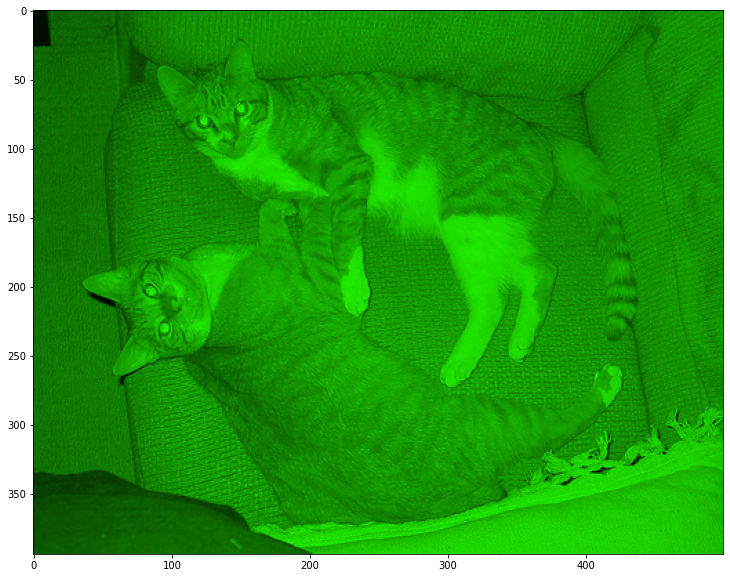

In [13]:
hue_img = col_aug.hue_rotate(0.6)
plt.imshow(Image.fromarray(hp.conv2uint8(hue_img.image_arr)))

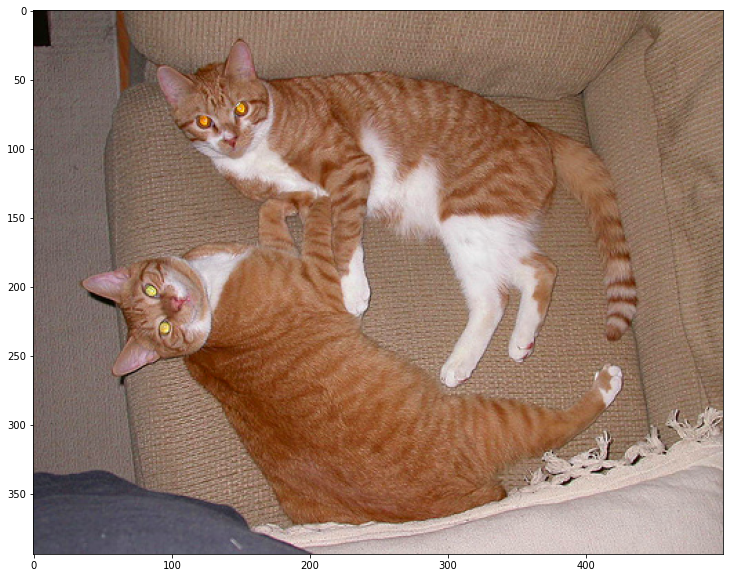

In [14]:
col_aug = praug.Color_Aug(image_path=imlabel_list[index][0], 
                    label_path=imlabel_list[index][1])
sat_img = col_aug.saturation(1.5)
plt.imshow(Image.fromarray(hp.conv2uint8(sat_img.image_arr)))

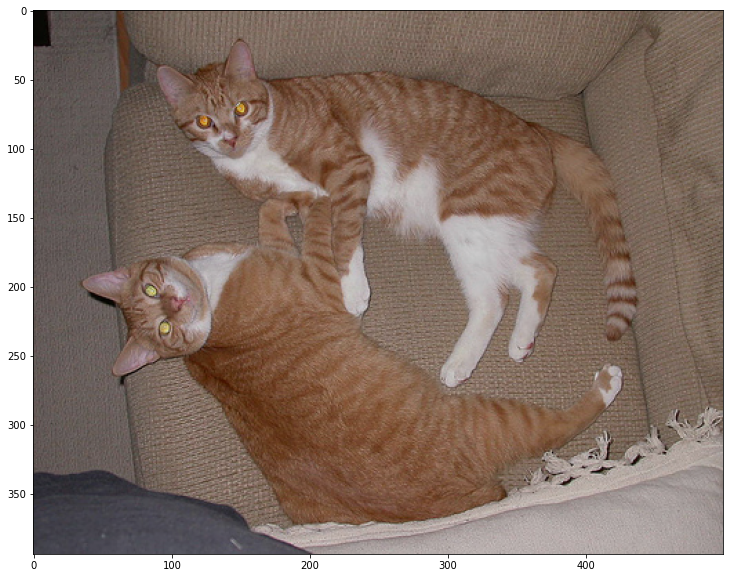

In [15]:
col_aug = praug.Color_Aug(image_path=imlabel_list[index][0], label_path=imlabel_list[index][1])
con_scale_img = col_aug.brightness(1.5)
plt.imshow(Image.fromarray(hp.conv2uint8(con_scale_img.image_arr)))

### Preparing Dataframe for Preprocessing & Augmentation

In [21]:
%%time
df = pd.DataFrame(columns = ['image_path','label_path','classes','bboxes'])
# df = pd.DataFrame()
# df['image_path'] = imlabel_list[:][0]
# df['label_path'] = imlabel_list[:][1]
# df.head()

for item,bar in zip(imlabel_list,tqnb(range(len(imlabel_list)),desc='Preparing dataframe')):
    # print(item)
    #bboxes = helper.fetch_bboxes(item[1]).tolist()
    bboxes,classes = hp.fetch_bbox_lb(item[1])
    df = df.append({'image_path':item[0], 'label_path': item[1],
                    'classes': classes, 'bboxes': bboxes}, ignore_index=True)
df.head()


CPU times: user 27.5 s, sys: 383 ms, total: 27.9 s
Wall time: 27.7 s


image_path  \
0  data/kitti/integration/original/training/image...   
1  data/kitti/integration/original/training/image...   
2  data/kitti/integration/original/training/image...   
3  data/kitti/integration/original/training/image...   
4  data/kitti/integration/original/training/image...   

                                          label_path  \
0  data/kitti/integration/original/training/label...   
1  data/kitti/integration/original/training/label...   
2  data/kitti/integration/original/training/label...   
3  data/kitti/integration/original/training/label...   
4  data/kitti/integration/original/training/label...   

                                  classes  \
0                                [person]   
1  [aeroplane, aeroplane, person, person]   
2       [aeroplane, aeroplane, aeroplane]   
3                             [tvmonitor]   
4                          [train, train]   

                                              bboxes  
0                     [[174.0, 101.0, 349.0, 351.0]]  
1  [[104.0, 78.0, 375.0, 183.0], [133.0, 88.0, 19...  
2  [[9.0, 107.0, 499.0, 263.0], [421.0, 200.0, 48...  
3                      [[156.0, 89.0, 344.0, 279.0]]  
4  [[263.0, 32.0, 500.0, 295.0], [1.0, 36.0, 235....

### Integrating the workflow for original KITTI dataset

In [47]:
# Resize Workflow
def resize_dataset(imlabel_list, newimgdir, newlbdir):
    dim = (960,544)
    resizeimg_info = {}

    for item,bar in zip(imlabel_list,tqnb(range(len(imlabel_list)),desc='Resizing Images')):
        resize_imgname = os.path.basename(item[0])[:-4] + '_resized'
        resize_lbboxnm = os.path.basename(item[1])[:-4] + '_resized'
        resizeimg_info['image_arr'], resizeimg_info['img_bboxes'] = resize_img_bbox((item[0],item[1]),dim)
        resizeimg_info['newimg_path'] = newimgdir + resize_imgname
        resizeimg_info['newlabel_path'] = newlbdir + resize_lbboxnm
        resizeimg_info['origlabel_path'] = item[1]

        save_newimgdata(resizeimg_info)
        time.sleep(0.000015)
# random start, end indices to be used for augmentation        
def start_end(start, diff, lends):
    end = start + diff
    if end > lends:
        newdiff = end - lends
        start = start - newdiff
        end = start + diff
    return start,end
    
# Augmentation Workflow
def aug_dataset(imlabel_list, img_path, label_path):
    image_info = {}
    
    lends = len(imlabel_list)
    diff = 2000
    randnum = int(gen_rand_num(0,lends))
    start,end = start_end(randnum,diff,lends)
    
    for i in range(0,2):
        for item,bar in zip(imlabel_list[start:end],
                            tqnb(range(len(imlabel_list[start:end])),desc='Augmenting Images')):
            print("Image File", item[0])
            # get the aug class
            aug_class = int(gen_rand_num(0,2))
            # get aug type
            num_types = len(aug_classes[aug_class]) - 1
            aug_type = int(gen_rand_num(0,num_types))
            # create aug class obj
            aug_class_obj = aug_classes[aug_class]['class'](item[0],item[1])
            # augment image_bbox object
            # aug_class_obj = aug_class_obj.aug_classes[aug_class][aug_type]
            # use get_attr to dynamically fetch the class method
            aug_class_method = getattr(aug_class_obj,aug_classes[aug_class][aug_type])
            # call the aug_type class method
            aug_class_obj = aug_class_method()
            # Fetching image, label names
            augimg_name = os.path.basename(item[0])[:-4] + '_'  + aug_classes[aug_class][aug_type]
            auglabel_name = os.path.basename(item[1])[:-4] + '_' + aug_classes[aug_class][aug_type]
            # Store image info in dictionary
            augimg_path = img_path + augimg_name
            auglabel_path = label_path + auglabel_name
            origlabel_path = item[1]

            image_info['newimg_path'] = augimg_path
            image_info['newlabel_path'] = auglabel_path
            image_info['origlabel_path'] = origlabel_path
            image_info['img_bboxes'] = aug_class_obj.bboxes
            image_info['image_arr'] = aug_class_obj.image_arr

            save_newimgdata(image_info)
            time.sleep(0.00095)

In [ ]:
# Fetch image and label path of dataset
impath = 'data/kitti/integration/original/training/image_2/'
labels_path = 'data/kitti/integration/original/training/label_2/'
imlabel_list = imlabel(impath, labels_path)
# testimpath = 'data/kitti/integration/original/testing/image_2/'
# testresizepath = 'data/kitti/integration/resized/testing/images/'
# testimgs = sorted(os.listdir(testimpath))
# for testimg,bar in zip(testimgs,tqnb(range(len(testimgs))):
    # just_resize_save(testimpath + testimg,testresizepath,(960,544))
    # time.sleep(0.1)
# Resize image and bboxes
newimgdir = 'data/kitti/integration/resized/training/images/'
newlbdir = 'data/kitti/integration/resized/training/labels/'
resize_dataset(imlabel_list, newimgdir, newlbdir)
# Augment image and bboxes
impath = 'data/kitti/integration/resized/training/images/'
labels_path = 'data/kitti/integration/resized/training/labels/'
imlabel_list = imlabel(newimgdir, newlbdir)
aug_dataset(imlabel_list, impath, labels_path)

In [ ]:
testimpath = 'data/kitti/integration/original/testing/image_2/'
testresizepath = 'data/kitti/integration/resized/testing/images/'
testimgs = sorted(os.listdir(testimpath))

for testimg,bar in zip(testimgs,tqnb(range(len(testimgs)),desc="Example")):
    print(testimg)
    #time.sleep(0.00095)